<a href="https://colab.research.google.com/github/VishalPallagani/Disaster-Prediction-from-Tweets/blob/master/EDA_and_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Kaggle Competition: [Real or Not? NLP with Disaster Tweets
Predict which Tweets are about real disasters and which ones are not](https://www.kaggle.com/c/nlp-getting-started/overview)

Steps to use Kaggle dataset with Google Colab 

In [1]:
!pip install -q kaggle

In [2]:
!pip install kaggle --upgrade

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.8)


In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vishalpallagani","key":"e8d59fec608c01741d5468cc0fe57df0"}'}

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 1.6MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.8-cp36-none-any.whl size=73275 sha256=110436ac329c5b00e930da6a46a80e252d737596738cdfbdd1c04261183bba6e
  Stored in directory: /root/.cache/pip/wheels/94/a7/09/68dc83c7c14fdbdf5d3f2b2da5b87e587bfc1e85df69b1130c
Successfully built kaggle
  Found existing installation: kaggle 1.5.8
    Uninstalling kaggle-1.5.8:
      Successfully uninstalled kaggle-1.5.8


In [7]:
! kaggle datasets list

ref                                                    title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
shivan118/healthcare-analytics                         AV : Healthcare Analytics                           2MB  2020-09-13 17:40:05           2013         94  0.9411765        
datatattle/covid-19-nlp-text-classification            Coronavirus tweets NLP - Text Classification        4MB  2020-09-08 11:40:11           1311         75  1.0              
anmolkumar/health-insurance-cross-sell-prediction      Health Insurance Cross Sell Prediction 🏠 🏥          6MB  2020-09-11 18:39:31           2366        157  1.0              
Cornell-University/arxiv                               arXiv Dataset                                     888MB  202

In [8]:
!kaggle competitions download -c nlp-getting-started -p /content

  0% 0.00/593k [00:00<?, ?B/s]
100% 593k/593k [00:00<00:00, 84.0MB/s]


In [9]:
!unzip \*.zip

Archive:  nlp-getting-started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


Notebook covers:


*   Basic EDA
*   Data Cleaning
*   Baseline Model



In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
nltk.download('stopwords')
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
import os

In [12]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


In [13]:
train_rows = train.shape[0]
train_cols = train.shape[1]
print(f"There are {train_rows} rows and {train_cols} columns in the train dataset")

There are 7613 rows and 5 columns in the train dataset


In [14]:
test_rows = test.shape[0]
test_cols = test.shape[1]
print(f"There are {test_rows} rows and {test_cols} columns in the train dataset")

There are 3263 rows and 4 columns in the train dataset


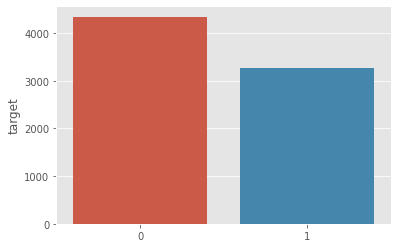

In [15]:
x = train.target.value_counts()
sns.barplot(x.index,x)

**EDA starts here**



1.   No. of chars in tweets




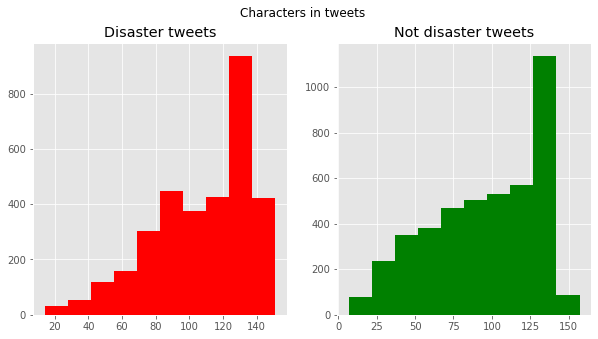

In [17]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=train[train['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('Disaster tweets')
tweet_len=train[train['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()




2.   No of words in a tweet




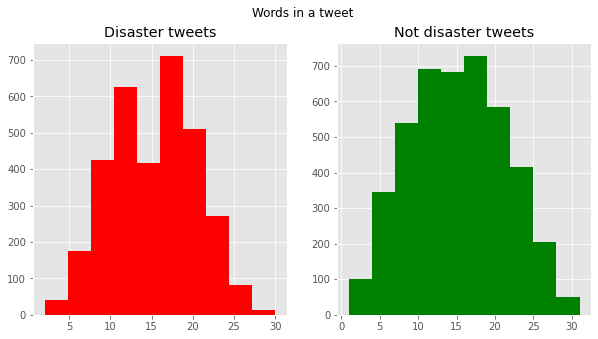

In [20]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=train[train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('Disaster tweets')
tweet_len=train[train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

Text(0.5, 0.98, 'Average word length in each tweet')

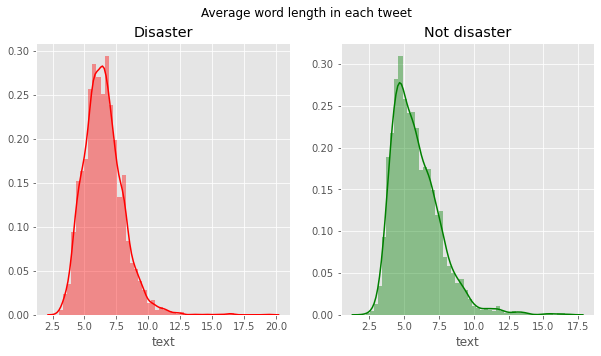

In [37]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=train[train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Disaster')
word=train[train['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

In [40]:
def create_corpus(target_val):
  corpus = []
  for x in train[train['target']==target_val]['text'].str.split():
    for i in x:
      corpus.append(i)
  return corpus

In [46]:
corpus=create_corpus(0)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
   
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 